In [1]:
#Description I'em Writing This Program Just Soo I Can Understand How Machine learning Actully Works..
#This Program Uses An Artificial Recurrent Neural Network Called Long Short Term Memory {LSTM},
#To Predict A Cloning Stock Prize Predictor Of A Coperation {Apple Inc.} Using The Past 60 Days Stock Prize...

In [29]:
#Here We Are Gonna Import Few libraries...
#Import Libraries
import sys
!{sys.executable} -m pip install --upgrade yfinance python-dotenv --user

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from dotenv import load_dotenv
import os

#Load .env File
dotenv_path = r"C:\Users\Shash\Python Anaconda Project\.env"
load_dotenv(dotenv_path)

#Load API Key
API_KEY = os.getenv("ALPHAVANTAGE_API_KEY")
print("API Key Loaded:", API_KEY is not None)
print(API_KEY[:4], "****", API_KEY[-4:])

#Optional: Check If .env Exists
print(os.path.exists(dotenv_path))



API Key Loaded: True
6HAP **** KE0Z
True


In [3]:
import pandas_datareader.data as web
import datetime

#Here We Get The Stock Quote...
#This Line Is CRUCIAL — It Tells Starting & Ending Dates
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2025, 12, 17)

#Here Display First 5 Rows To Show the Data
try:
    df = web.DataReader('AAPL', 'stooq', start, end)
    df = df.sort_index()  # Stooq gives newest first
    print(df.head(70))
except Exception as e:
    print("Error fetching data:", e)
    df.to_csv("AAPL_full_data.csv")
print("Saved all data to AAPL_full_data.csv")

               Open     High      Low    Close     Volume
Date                                                     
2019-01-02  36.8214  37.7585  36.6595  37.5385  155820440
2019-01-03  34.2268  34.6362  33.7543  33.7995  384136278
2019-01-04  34.3563  35.3120  34.1833  35.2414  246550878
2019-01-07  35.3453  35.3768  34.6813  35.1607  230441584
2019-01-08  35.5535  36.0898  35.3042  35.8306  172587151
...             ...      ...      ...      ...        ...
2019-04-05  46.8993  47.0524  46.7725  47.0300   77605886
2019-04-08  46.8924  47.8040  46.8729  47.7734  108415314
2019-04-09  47.8215  48.4267  47.5631  47.6271  149828848
2019-04-10  47.4296  47.9216  47.3117  47.8925   90878960
2019-04-11  47.9472  47.9816  47.3726  47.4943   87550974

[70 rows x 5 columns]
Saved all data to AAPL_full_data.csv


In [4]:
#Here We Get The Number Of Rows & Columns In The Data Set
df.shape

(1751, 5)

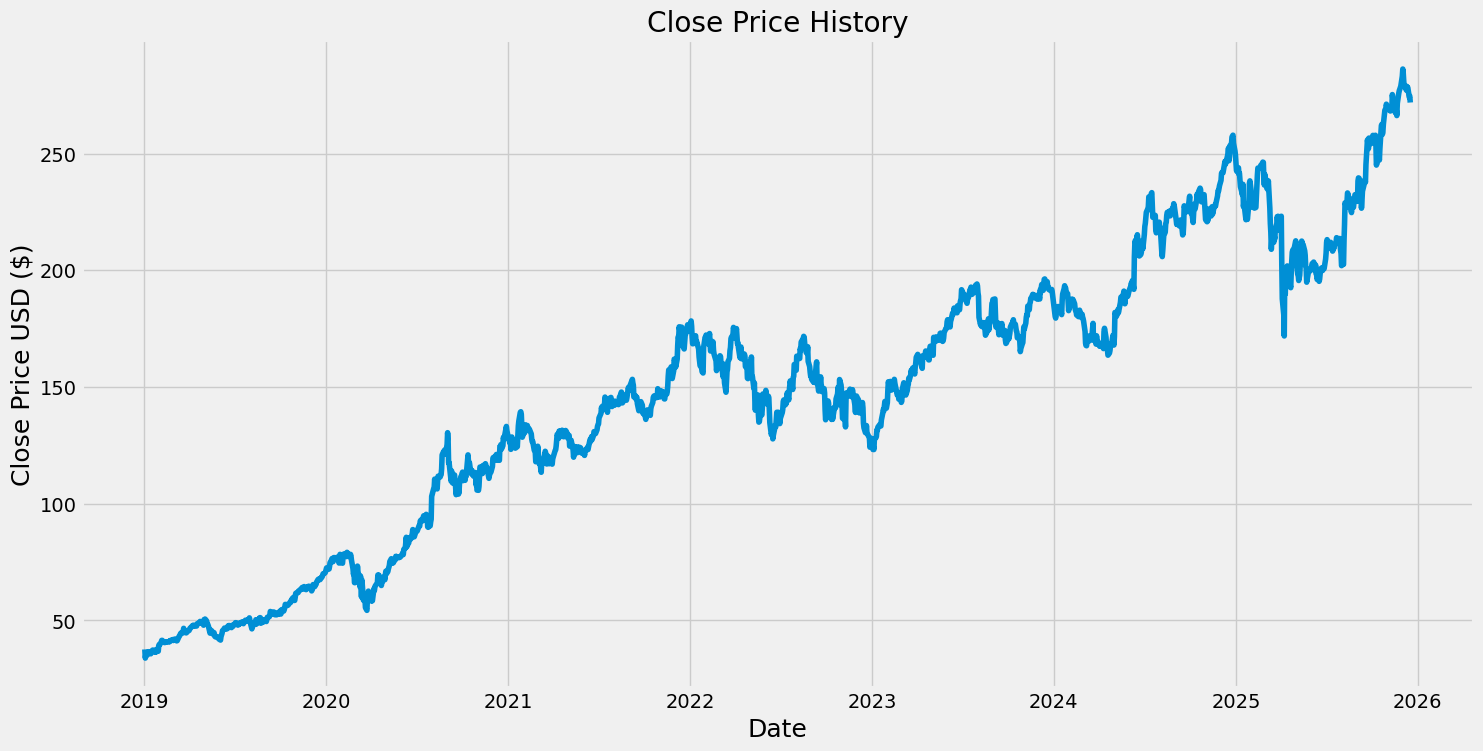

In [5]:
#Here We Are Visualize Closing Price History
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show() 

In [6]:
#Here We Create A New Dataframe With Only The Close Column
data = df.filter(['Close'])
#Convert The Dataframe To A Numpy Array
dataset = data.values
#Get The Number Of Rows To Train The LSTM Model On
training_data_len = math.ceil(len(dataset) * 0.8)
print("training_data_len =", training_data_len)


training_data_len = 1401


In [7]:
#Here We Are Gonna Scale The Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data


array([[0.01481435],
       [0.        ],
       [0.00571297],
       ...,
       [0.95213766],
       [0.95411872],
       [0.94314366]])

In [8]:
# Here We Are Gonna Create The Training Data Set
# Create The Scaled Training Data Set
train_data = scaled_data[0:training_data_len, :]

# Split The Data Into X_Train & Y_Train Data Sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

    # Optional: only for debugging like in the video
    if i <= 61:
        print(x_train)
        print(y_train)
        print()


[array([0.01481435, 0.        , 0.00571297, 0.00539323, 0.00804745,
       0.01046711, 0.01093108, 0.00951858, 0.00736993, 0.01026148,
       0.01202026, 0.01287608, 0.01377112, 0.01045919, 0.01103092,
       0.00989974, 0.01467012, 0.01328497, 0.01177144, 0.02171041,
       0.02284595, 0.02291172, 0.027379  , 0.03012633, 0.03018458,
       0.02707947, 0.02727361, 0.02633697, 0.02771816, 0.02705173,
       0.02763535, 0.0272855 , 0.02775303, 0.02880695, 0.02787704,
       0.02968693, 0.03087398, 0.03097145, 0.03148454, 0.02986562,
       0.03157845, 0.03242238, 0.03211928, 0.03114618, 0.0292515 ,
       0.02963305, 0.03529887, 0.03720861, 0.03795626, 0.03986679,
       0.04212718, 0.04392558, 0.04251309, 0.04406267, 0.05059897,
       0.04678504, 0.04462212, 0.04276548, 0.04436221, 0.04460271])]
[np.float64(0.04574260917110587)]

[array([0.01481435, 0.        , 0.00571297, 0.00539323, 0.00804745,
       0.01046711, 0.01093108, 0.00951858, 0.00736993, 0.01026148,
       0.01202026, 0.01

In [9]:
#Here We Convert The X_train & Y_train To Numpy Arrays
x_train, y_train = np.array(x_train), np.array(y_train)
print("Before reshape:", x_train.shape)

Before reshape: (1341, 60)


In [10]:
#Here We Are Gonna Reshape The Data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("After reshape:", x_train.shape)

After reshape: (1341, 60, 1)


In [11]:
#Here We Are Gonna Build The LSTM Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input

#1. Initialize the model FIRST
model = Sequential()

#2. Add the layers
model.add(Input(shape=(x_train.shape[1], 1))) 
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [12]:
#Here We Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [13]:
#Train (fit) the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1341/1341 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - loss: 0.0013


In [14]:
#Here We Create The Testing Data
#Here We Create A New Array Containing Scaled Values From Index 1543 To 2003
test_data = scaled_data[training_data_len - 60: , :]
#Here We Create The Data Sets x_test & y_test
x_test = []
y_test = dataset [training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    

In [15]:
#Here We Convert The Data To A Numpy Array
x_test = np.array(x_test)


In [16]:
#Here We Reshape The Data
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1 ))


In [17]:
#Here We Get The Models Predicted Price Values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step 


In [18]:
#Here We Get The Root Mean Squared Error (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

np.float64(1.9975238260323664)

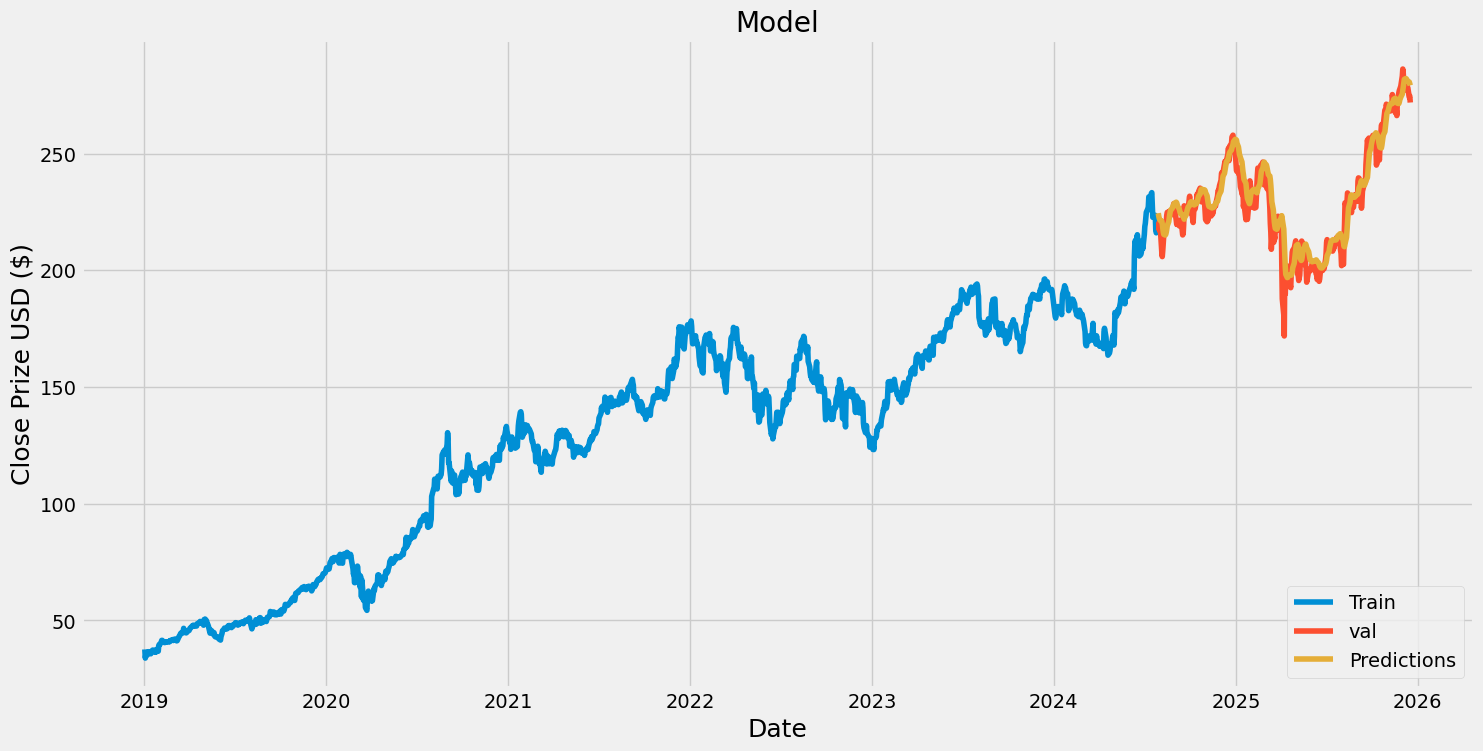

In [19]:
#Here We Plot The Data
train = data[:training_data_len]
valid = data[training_data_len:].copy()  

valid.loc[:, 'Predictions'] = predictions  

#Here We Are Gonna Visualize The Data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Prize USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'], label="Predictions")
plt.legend(['Train','val','Predictions'], loc='lower right')
plt.show()


In [20]:
#Here We Show The Valid & Predicted Prices
valid

,Close,Predictions
Date,,
2024-07-29,216.768,224.446747
2024-07-30,217.323,223.140579
2024-07-31,220.581,222.146027
2024-08-01,216.888,221.768768
2024-08-02,218.377,221.323730
...,...,...
2025-12-11,278.030,281.300140
2025-12-12,278.280,280.939423
2025-12-15,274.110,280.632446


In [21]:
#Here We Get The Quote
apple_quote = yf.download(
    tickers="AAPL",
    period="2d",   # fetch last 2 days to be safe
    interval="1d",
    progress=False,
    auto_adjust=True
)

print(apple_quote['Close'])



Ticker            AAPL
Date                  
2026-01-23  248.039993
2026-01-26  254.550003


In [22]:
#Here We Are Gonna Fix Everything
import requests
import pandas as pd
import os

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY")
CACHE_FILE = "last_price_cache.csv"

# ---- Alpha Vantage Fetch ----
def fetch_alpha(symbol="AAPL"):
    url = (
        "https://www.alphavantage.co/query?"
        f"function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={API_KEY}"
    )

    try:
        r = requests.get(url, timeout=10)
        data = r.json()
    except Exception as e:
        print("Alpha request failed:", e)
        return None

    if "Time Series (Daily)" not in data:
        print("Alpha response:", data)
        return None

    ts = data["Time Series (Daily)"]
    df = pd.DataFrame(ts).T.astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    return df[["5. adjusted close"]].rename(columns={"5. adjusted close": "Close"})

# ---- Stooq Fetch ----
def fetch_stooq(symbol="AAPL"):
    url = f"https://stooq.com/q/d/l/?s={symbol.lower()}&i=d"
    try:
        df = pd.read_csv(url)
    except Exception as e:
        print("Stooq request failed:", e)
        return None

    # Handle missing header weirdness
    if df.columns[0].lower().startswith("unnamed"):
        df.rename(columns={df.columns[0]: "Date"}, inplace=True)

    df.columns = [c.strip().title() for c in df.columns]

    if "Date" not in df.columns or "Close" not in df.columns:
        return None

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date")

    return df[["Date", "Close"]].set_index("Date")

# ---- Latest Close Fetch with Fallback ----
def fetch_latest_close(symbol="AAPL"):
    print("Trying Alpha Vantage...")
    df = fetch_alpha(symbol)
    if df is not None and not df.empty:
        df.to_csv(CACHE_FILE)
        print("✅ Alpha Vantage success")
        return df

    print("Alpha Vantage failed. Trying Stooq...")
    df = fetch_stooq(symbol)
    if df is not None and not df.empty:
        df.to_csv(CACHE_FILE)
        print("✅ Stooq success")
        return df

    print("Both APIs failed. Trying cache...")
    if os.path.exists(CACHE_FILE):
        df = pd.read_csv(CACHE_FILE, index_col=0, parse_dates=True)
        print("⚠️ Using cached data")
        return df

    raise ValueError("All data sources failed. No cached data available.")

# ---- TEST ----
apple_quote = fetch_latest_close("AAPL")
print("Total rows:", len(apple_quote))
print(apple_quote.tail())

latest_close = apple_quote.iloc[-1]["Close"]
print("Latest Close:", latest_close)


Trying Alpha Vantage...
Alpha response: {'Information': 'Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints'}
Alpha Vantage failed. Trying Stooq...
Both APIs failed. Trying cache...
⚠️ Using cached data
Total rows: 100
             Close
2026-01-16  255.53
2026-01-20  246.70
2026-01-21  247.65
2026-01-22  248.35
2026-01-23  248.04
Latest Close: 248.04


In [23]:
#Here We Are Gonna Fetch Data
apple_quote = fetch_latest_close("AAPL")
print(apple_quote.tail())

latest_close = apple_quote.iloc[-1]["Close"]
print("Latest Close:", latest_close)

Trying Alpha Vantage...
Alpha response: {'Information': 'Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints'}
Alpha Vantage failed. Trying Stooq...
Both APIs failed. Trying cache...
⚠️ Using cached data
             Close
2026-01-16  255.53
2026-01-20  246.70
2026-01-21  247.65
2026-01-22  248.35
2026-01-23  248.04
Latest Close: 248.04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


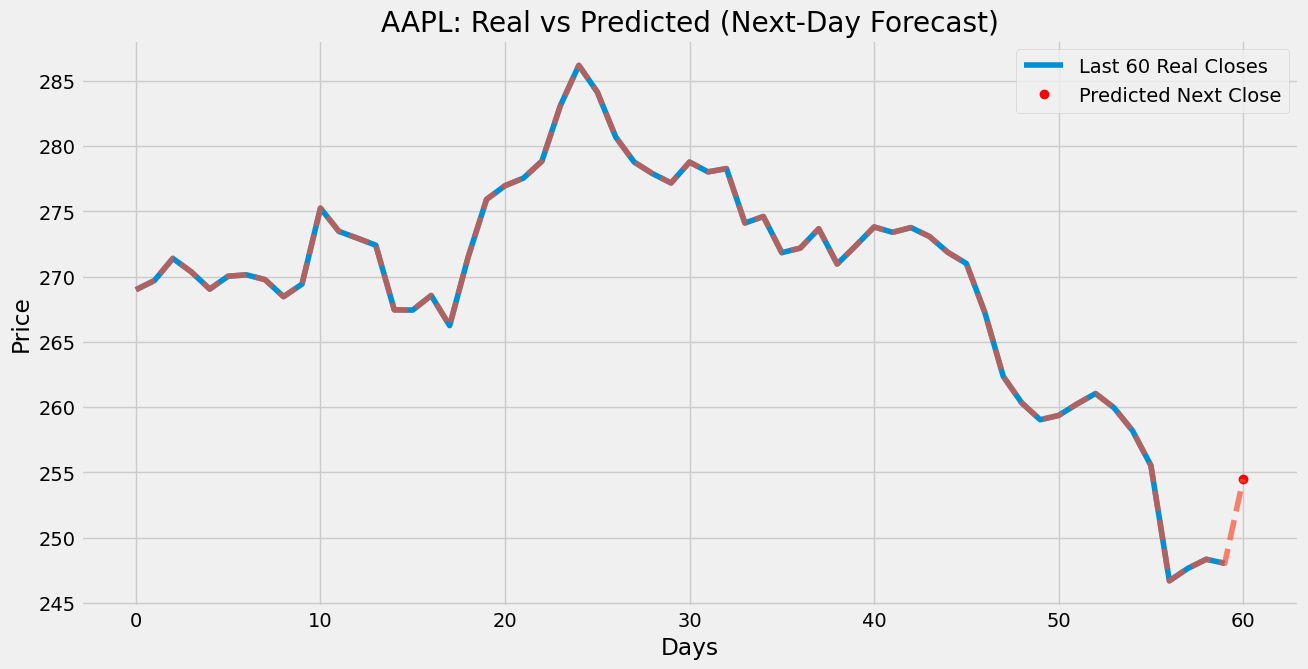

In [24]:
import matplotlib.pyplot as plt
import numpy as np

if "close_prices" not in globals():
    close_prices = apple_quote["Close"].values.reshape(-1, 1)

if "predicted_price" not in globals():
    window_size = 60
    last_window = close_prices[-window_size:]
    scaled_last_window = scaler.transform(last_window)
    X_test = scaled_last_window.reshape(1, window_size, 1)

    predicted_scaled = model.predict(X_test)
    predicted_price = scaler.inverse_transform(predicted_scaled)

last_real = close_prices[-60:].flatten()
extended = np.append(last_real, predicted_price[0][0])

plt.figure(figsize=(14, 7))
plt.plot(range(60), last_real, label="Last 60 Real Closes")
plt.plot(60, predicted_price[0][0], "ro", label="Predicted Next Close")
plt.plot(range(61), extended, linestyle="--", alpha=0.7)

plt.legend()
plt.title("AAPL: Real vs Predicted (Next-Day Forecast)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.show()


In [25]:
import yfinance as yf
import numpy as np

# ---- 0. Fetch enough historical data ----
# Make sure we have at least 90 days to cover 60-day windows
apple_quote = yf.download(
    tickers="AAPL",
    period="90d",    # fetch last 90 days
    interval="1d",
    progress=False,
    auto_adjust=True
)

# ---- 1. Get closing prices ----
close_prices = apple_quote["Close"].values.reshape(-1, 1)
print("Total data points fetched:", len(close_prices))

# ---- 2. Safety check ----
window_size = 60
if len(close_prices) < window_size:
    raise ValueError(
        f"Not enough data to build a {window_size}-day window. "
        f"Only {len(close_prices)} days available."
    )

# ---- 3. Scale using your EXISTING scaler ----
# NOTE: 'scaler' must be defined elsewhere and already fitted
scaled_prices = scaler.transform(close_prices)

# ---- 4. Build last 60-day window ----
last_window = scaled_prices[-window_size:]
X_test = last_window.reshape(1, window_size, 1)

# ---- 5. Predict ----
# NOTE: 'model' must be defined and trained already
predicted_scaled = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_scaled)

print("📈 Predicted Next Close:", float(predicted_price[0][0]))


Total data points fetched: 90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
📈 Predicted Next Close: 253.96694946289062


In [26]:
#Here We Get The Quote
import yfinance as yf
import pandas as pd
import numpy as np
import time
import requests

API_KEY = "6HAP8BV2LOSKKE0Z"

def fetch_latest_close(ticker="AAPL", retries=3, delay=5):
    for attempt in range(retries):
        try:
            df = yf.download(
                tickers=ticker,
                period="7d",
                interval="1d",
                progress=False
            )

            if not df.empty:
                return df[['Close']]

            print(f"Attempt {attempt+1}: Empty data, retrying...")

        except Exception as e:
            print(f"Attempt {attempt+1} failed:", e)

        time.sleep(delay)

    raise ValueError("Yahoo API failed after multiple attempts.")

#Initial Fetch
apple_quote = yf.download(
    tickers="AAPL",
    start="2019-01-01",
    end="2025-01-17",
    progress=False,
    auto_adjust=True
)

# Safety check
apple_quote = fetch_latest_close("AAPL")
new_df = apple_quote
if apple_quote.empty:
    raise ValueError("Yahoo API returned empty data. Try again in 30 seconds.")

new_df = apple_quote[['Close']]

#Here We Get The Last Closing Price Values & Convert the Data-Frame To An Array
last_60_days = new_df[-60:].values

#Here We Scale The Data To Be Values Between 0 & 1
last_60_days_scaled = scaler.transform(last_60_days)  # scaler must be defined earlier

#Here We Create An Empty List
X_test = []

#Here We Append The Past 60 Days
X_test.append(last_60_days_scaled)

#Here We Convert The X_test
X_test = np.array(X_test)

#Here We Reshape The Data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Here We Get The Predicted Scaled Price
pred_price = model.predict(X_test)  # model must be defined earlier

#Here We Undo The Scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

# ---- Stooq Fetch ----
def fetch_latest_close_stooq(symbol="AAPL"):
    url = f"https://stooq.com/q/d/l/?s={symbol.lower()}&i=d"
    df = pd.read_csv(url)

    #Here We Are If First Column Is Unnamed → Treat It As Date
    if df.columns[0].lower().startswith("unnamed"):
        df.rename(columns={df.columns[0]: "Date"}, inplace=True)

    #Here We Are Normalize Column names
    df.columns = [c.strip().title() for c in df.columns]

    #Here We check Final Safety Check
    if "Date" not in df.columns or "Close" not in df.columns:
        print("Columns received:", df.columns.tolist())
        raise ValueError("Stooq format changed. Date/Close column missing.")

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date")

    return df[["Date", "Close"]].set_index("Date")

# ---- Alpha Vantage Fetch ----
def fetch_alpha(symbol="AAPL"):
    url = (
        "https://www.alphavantage.co/query?"
        f"function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={API_KEY}"
    )

    r = requests.get(url, timeout=10)
    data = r.json()

    if "Time Series (Daily)" not in data:
        return None

    ts = data["Time Series (Daily)"]
    df = pd.DataFrame(ts).T.astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    return df[["5. adjusted close"]].rename(columns={"5. adjusted close": "Close"})


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
[[225.56053]]
